In [1]:
from data import Data
import matplotlib.pyplot as plt
import torch
from torch import nn

**Teacher Forcing** (open loop) is a training technique used in sequence-based deep learning models, particularly in recurrent neural networks (RNNs), LSTMs, and GRUs, where the model predicts the next element in a sequence. During training, instead of using the model’s predicted output at the current time step as input for the next step, the actual ground truth (correct) value is fed into the network. This helps the model learn faster by providing correct context from the true sequence during training. However, at inference time, since the ground truth is not available, the model must rely on its own predictions. This can lead to discrepancies between training and testing performance, as the model might accumulate errors if its predictions deviate from the correct sequence.

**Closed loop**, on the other hand, refers to the scenario where a model's outputs at each time step are fed back as inputs for the subsequent steps. This process happens during inference, where the model relies on its own predictions rather than external ground truth data. The closed loop structure mimics real-world deployment conditions, where a model must continue generating sequences or outputs based on prior predictions.

In contrast, during teacher forcing (open loop), the model is trained using ground truth inputs at each step rather than relying on its own predictions. The closed loop can sometimes lead to compounding errors, especially if the model's early predictions deviate from the true sequence, causing future predictions to be inaccurate. While teacher forcing accelerates learning by providing the correct context during training, models trained this way may struggle during inference when forced into a closed loop. As a result, there’s often a trade-off between training with teacher forcing and a model’s generalization ability in a closed loop environment.

Here, a hybrid training strategy is employed where the model initially uses teacher forcing for the first part of the sequence (in this case, for the first 65 steps). During this phase, the model is provided with the correct, ground-truth sequence at each step to learn effectively and accelerate convergence. This helps the model to better capture the relationships between sequence elements early on, without relying on its own possibly imperfect predictions.

After the first 65 steps, the model switches to a closed loop strategy, where it starts using its own predicted outputs as inputs for subsequent steps. This allows the model to gradually adapt to the real-world deployment scenario, where ground-truth data won’t be available, and it must rely on its own outputs. By combining both techniques, the model benefits from the rapid learning of teacher forcing and the robustness of closed-loop inference, which reduces the discrepancy between training and inference behavior, leading to better generalization during testing or real-world application.

In [2]:
class RNN_model(nn.Module):
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens,bias=False)
        self.linear = nn.Linear(num_hiddens, num_out,bias=False)

    def forward(self, X, H, num, num_res=0):
        if num_res==0:
            num_res = len(X) 
        pred_list = []
        for i in range(num_res):
            if i < num: #teacher forcing
                out, H = self.rnn(X[i].reshape(1,1),H)
                pred_out = self.linear(out)
            else: #closed loop
                out, H = self.rnn(pred_out, H)
                pred_out = self.linear(out)
                
            pred_list.append(pred_out)
        pred_tens = torch.stack(pred_list).reshape(num_res)
        return pred_tens, H

In [3]:
def train(model, X, optimizer, criterion, H, num):
    model.train()
    optimizer.zero_grad()
    y_hat,H = model(X,H,num)
    loss = criterion(X[1:],y_hat[:-1])
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(loss.detach())

In [4]:
data = Data(0.1,100,0.)
X = data.x
H = torch.zeros(1,2)
mse_loss = nn.MSELoss()
model = RNN_model(1,2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(5001):
    H = torch.zeros(1,2)
    train(model, X, optimizer, mse_loss, H, 64)

tensor(0.4259)
tensor(0.0107)
tensor(0.0057)
tensor(0.0036)
tensor(0.0023)
tensor(0.0016)


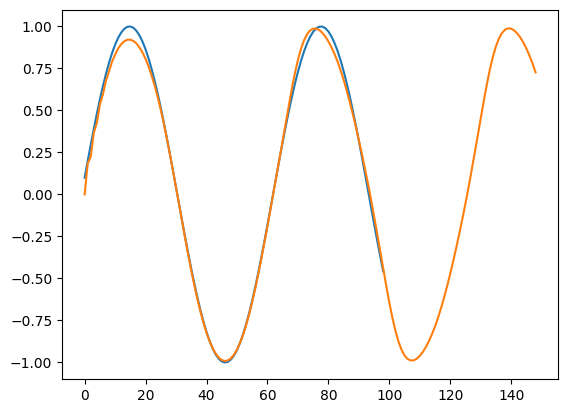

In [5]:
H = torch.zeros(1,2)
y, H = model(X, H, 65,150)
y = y.detach()
plt.plot(X[1:])
plt.plot(y[:-1])

Note: This code doesn't always produce the correct result. The accuracy of the approximation depends on 'luck', random initialization of the model weights.

In [6]:
for params in model.parameters():
    print(params.detach())

tensor([[-0.3648],
        [ 0.9332]])
tensor([[ 0.9733,  0.7907],
        [ 0.1772, -0.6835]])
tensor([[-0.3086,  1.8598]])
